In [14]:
# Cell 1: Import necessary libraries
import matplotlib.pyplot as plt  # For generating plots
import numpy as np  # For numerical operations
import cv2  # For image processing
from tqdm import trange  # For progress bars in loops
from gymnasium.utils.env_checker import check_env  # For environment validation in simulations
from flygym import Fly, Camera  # For creating and managing the fly and camera in the simulation
from flygym.arena import FlatTerrain, OdorArena  # For setting up simulation environments
from flygym.examples.turning_controller import HybridTurningNMF  # For neural network based movement control
from pathlib import Path  # For handling filesystem paths

# Cell 2: Define parameters
Path("./outputs/outputs_finaux").mkdir(exist_ok=True)  # Create the output directory if it doesn't exist

# Define odor source parameters
peak_odor_intensity = np.array([[1, 0]])  # Intensity of odor at the source
odor_source_A = np.array([[-8, 1, 0.2]])  # Coordinates of the odor source

# Color settings for visual markers in the simulation
marker_colors = [[255, 127, 14]]  # Base color for markers
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])  # Normalizing colors to [0,1]

# Create the simulation arena with specific characteristics
arena = OdorArena(
    odor_source=odor_source_A,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,  # Diffusion function for the odor
    marker_colors=marker_colors,
    marker_size=0.3  # Size of the markers on the simulation display
)

# Cell 5: Setup the fly and camera
# Define sensor placements for the simulated fly
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# Initialize the fly in the simulation
fly = Fly(
    spawn_pos=(0, 3, 0.2),  # Position of the fly at start
    spawn_orientation=(0, 0, 0),  # Orientation of the fly
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,  # Enable the sense of smell
    enable_adhesion=True,  # Enable sticking to surfaces
    draw_adhesion=False  # Do not display adhesion effects
)

# Set up the camera to observe the simulation
cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.2,  # Speed of the simulation playback
    window_size=(1000, 608)  # Size of the display window
)

# Initialize the simulation controller with the fly and camera
sim = HybridTurningNMF(
    fly=fly,
    cameras=[cam],
    arena=arena
)

# Simulation parameters for runtime configuration
global white_area_bounds, attractive_gain, aversive_gain, decision_interval, run_time, num_decision_steps, physics_steps_per_decision_step, speed, curr_time, initial_xpos, n_delays
odor_dimensions = len(peak_odor_intensity[0])  # Dimensionality of the odor intensity array
white_area_bounds = [[0, 0], [0, 0]]  # Bounds for a special area in the simulation
attractive_gain = -500  # Gain for attractive behavior
aversive_gain = 500  # Gain for aversive behavior
decision_interval = 0.05  # Time between decisions
run_time = 5  # Total run time of the simulation
num_decision_steps = int(run_time / decision_interval)  # Number of decision steps
physics_steps_per_decision_step = int(decision_interval / sim.timestep)  # Physical steps per decision step
speed = 5  # Speed of the fly
curr_time = 0  # Current simulation time
initial_xpos = odor_source_A[0][0]  # Initial x position of the odor source
n_delays = 10  # Number of delay steps for processing

# Cell 3: Define utility functions
def draw_white_area_corners(frame, bounds, color=(0, 0, 255), size=5):
    """Draw rectangles at the corners of a defined area to visualize boundaries."""
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    corners = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
    for corner in corners:
        pixel_x = int((corner[0] + 6.75) * 100)  # Scaling factor for display
        pixel_y = int((corner[1] - 0.46) * 100)
        cv2.circle(frame, (pixel_x, pixel_y), size, color, -1)
    return frame

def is_in_white_area(position, bounds):
    """Check if a given position is within defined bounds."""
    x, y = position[:2]
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    return x1 <= x <= x2 and y1 <= y <= y2

def run_simulation(fly_mobile=True, source_mobile=False, bounds=False, white_area_bounds=white_area_bounds, bounds_speed=np.array([[0.03, 0.0], [0.03, 0.0]]), n_delays=n_delays):
    """ Conducts the simulation with configured parameters. """
    global curr_time, initial_xpos, x_positions, times, obs_hist, odor_history, antennae_positions, O, HRC_model
    x_positions = []
    times = []
    obs_hist = []
    odor_history = []
    antennae_positions = []
    delayed_intensities = []
    obs, _ = sim.reset()  # Reset the simulation to start fresh.

    for i in trange(num_decision_steps):
        antennae_pos = sim.physics.bind(fly._antennae_sensors).sensordata
        antennae_pos = antennae_pos.reshape(-1, 3)  # Reformat sensor data for processing.
        antennae_positions.append(antennae_pos)
        if bounds:  # Adjust odor intensity based on position within bounds.
            white_area_bounds += bounds_speed
            odor_intensity = arena.get_olfaction(antennae_pos)
            for idx, sensor_pos in enumerate(antennae_pos):
                if not is_in_white_area(sensor_pos, white_area_bounds):
                    odor_intensity[:, idx] = 0
                    obs["odor_intensity"] = odor_intensity.astype(np.float32)

        attractive_intensities = np.average(
            obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
        )
        aversive_intensities = np.average(
            obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
        )

        control_signal = np.zeros((2,))

        delayed_intensities = O.pop(0)
        current_intensities = [obs["odor_intensity"][0, :][1], obs["odor_intensity"][0, :][3]]
        O.append(current_intensities)
        HRC_model.append(delayed_intensities[0] * current_intensities[1] - delayed_intensities[1] * current_intensities[0])

        odor_history.append(attractive_intensities + aversive_intensities)
        if source_mobile:
            xpos += 0.03
        if bounds:
            xposA += 0.03
            xposB += 0.03

        for j in range(physics_steps_per_decision_step):
            curr_time += sim.timestep
            times.append(curr_time)
            x_positions.append(xpos)

            if source_mobile:
                sim.physics.bind(marker).mocap_pos[:2] = [xpos, 1]
                arena.odor_source[0, :2] = [xpos, 1]
            if bounds:
                sim.physics.bind(markerA).mocap_pos[:2] = [xposA, -5]
                arena.odor_source[1, :2] = [xposA, -5]
                sim.physics.bind(markerB).mocap_pos[:2] = [xposB, 5]
                arena.odor_source[2, :2] = [xposB, 5]

            obs, _, _, _, _ = sim.step(control_signal)
            rendered_img = sim.render()[0]
            if rendered_img is not None:
                hrc_value = HRC_model[-1] if HRC_model else 0
                im = cv2.putText(
                    rendered_img,
                    f"HRC Model: {hrc_value:.8f}",
                    (100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 0),
                    2,
                    cv2.LINE_AA
                )
                cam._frames[-1] = im

            obs_hist.append(obs)




In [9]:

run_simulation(fly_mobile=False, source_mobile=True,bounds=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:16<00:00,  4.36s/it]


In [10]:
x = list(range(num_decision_steps))
print(len(x))
#divide x by 100
x = [((i+1)*48) / 200 for i in x]
x

100


[0.24,
 0.48,
 0.72,
 0.96,
 1.2,
 1.44,
 1.68,
 1.92,
 2.16,
 2.4,
 2.64,
 2.88,
 3.12,
 3.36,
 3.6,
 3.84,
 4.08,
 4.32,
 4.56,
 4.8,
 5.04,
 5.28,
 5.52,
 5.76,
 6.0,
 6.24,
 6.48,
 6.72,
 6.96,
 7.2,
 7.44,
 7.68,
 7.92,
 8.16,
 8.4,
 8.64,
 8.88,
 9.12,
 9.36,
 9.6,
 9.84,
 10.08,
 10.32,
 10.56,
 10.8,
 11.04,
 11.28,
 11.52,
 11.76,
 12.0,
 12.24,
 12.48,
 12.72,
 12.96,
 13.2,
 13.44,
 13.68,
 13.92,
 14.16,
 14.4,
 14.64,
 14.88,
 15.12,
 15.36,
 15.6,
 15.84,
 16.08,
 16.32,
 16.56,
 16.8,
 17.04,
 17.28,
 17.52,
 17.76,
 18.0,
 18.24,
 18.48,
 18.72,
 18.96,
 19.2,
 19.44,
 19.68,
 19.92,
 20.16,
 20.4,
 20.64,
 20.88,
 21.12,
 21.36,
 21.6,
 21.84,
 22.08,
 22.32,
 22.56,
 22.8,
 23.04,
 23.28,
 23.52,
 23.76,
 24.0]

In [11]:
cam.save_video("./outputs/outputs_finaux/exp_A_1_1.mp4")
#show graph HRC_model through time

[swscaler @ 0x7f81b42c8000] Warning: data is not aligned! This can lead to a speed loss


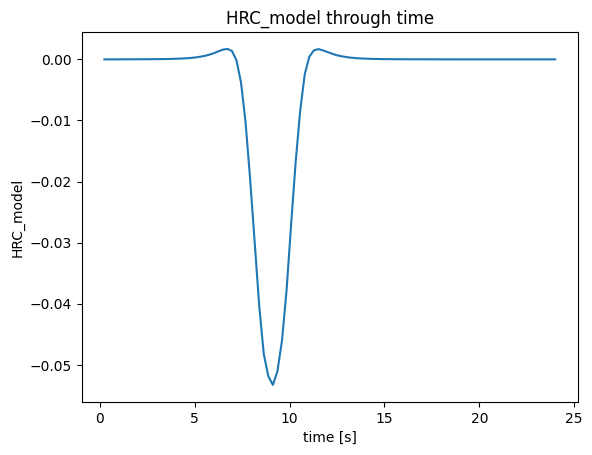

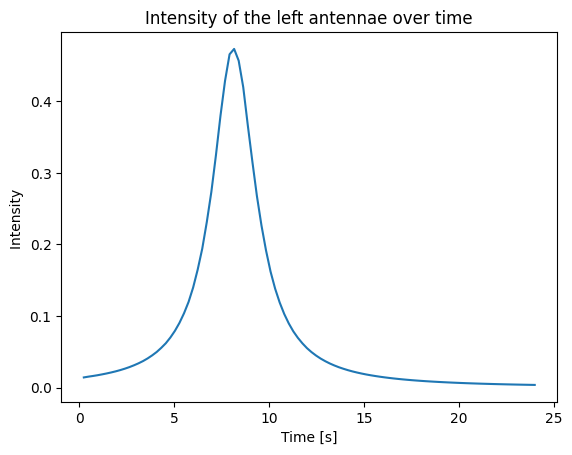

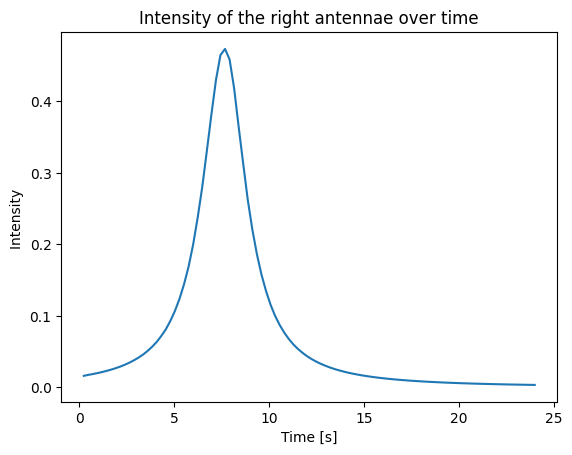

In [12]:

plt.plot(x,HRC_model)
 #change the values of the xlabel

plt.xlabel('time [s]')
plt.ylabel('HRC_model')
plt.title('HRC_model through time')
plt.savefig("./outputs/outputs_finaux/HRC_exp_A_1_1.png")
plt.show()

#HRC_model

# Extract the first column from odor_history
first_column = [entry[0] for entry in odor_history]

# Plot the first column
plt.plot(x,first_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the left antennae over time')
plt.savefig("./outputs/outputs_finaux/antenne_1_exp_A_1_1.png")
plt.show()

# Extract the second column from odor_history
second_column = [entry[1] for entry in odor_history]

# Plot the second column
plt.plot(x,second_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the right antennae over time')
plt.savefig("./outputs/outputs_finaux/antenne_2_exp_A_1_1.png")
plt.show()